In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
from scipy import linalg as la

1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


True
True
the variability for the first eigenvalue is: (0.9304059050499719+0j)


Text(0.5, 1.0, 'Rotated scatter plot')

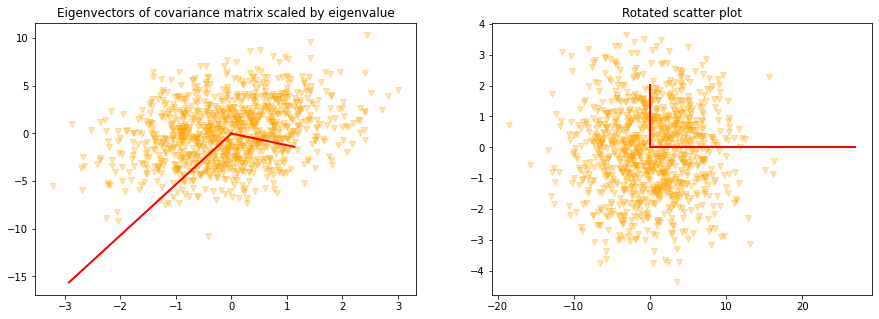

In [10]:
x1=np.random.randn(1000)
x2=x1+npr.normal(0,3,1000)
x3=2*x1+x2
dataset=np.array([x1,x2,x3])

mCov=np.cov(dataset)
l,V=la.eig(mCov)
U,spectrum,Vt=la.svd(mCov)
D=np.zeros((3,3))
for i in range(min(3,3)):
    D[i, i] = spectrum[i]
SVD=np.dot(U, np.dot(D, Vt))
lnew, Vnew = la.eig(SVD)
print(np.allclose(lnew,l))
print(np.allclose(Vnew,V))

Lambda=np.diag(l)
print ('the variability for the first eigenvalue is:',Lambda[0,0]/Lambda.trace())

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.scatter(dataset[0,:],dataset[1,:], alpha=0.3, color='orange', marker='v')
for n,m in zip(l, V.T):
    ax1.plot([0, n*m[0]], [0, n*m[1]], 'r-', lw=2)
ax1.set_title('Eigenvectors of covariance matrix scaled by eigenvalue')

rot=np.dot(V.T, dataset)
ax2.scatter(rot[0,:], rot[2,:], alpha=0.3, color='orange', marker='v')
for g, k in zip(lrot, np.diag([1]*3)):
    ax2.plot([0, g*k[0]], [0, g*k[2]], 'r-', lw=2)
ax2.set_title('Rotated scatter plot')

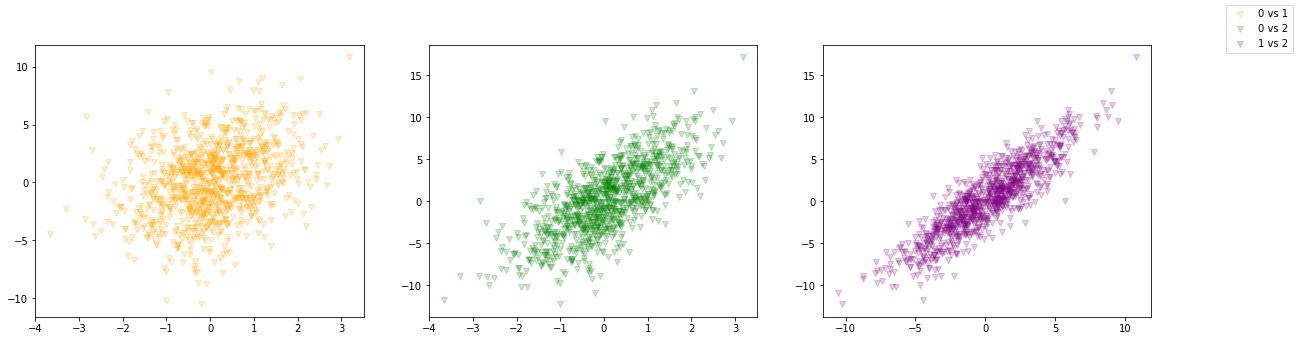

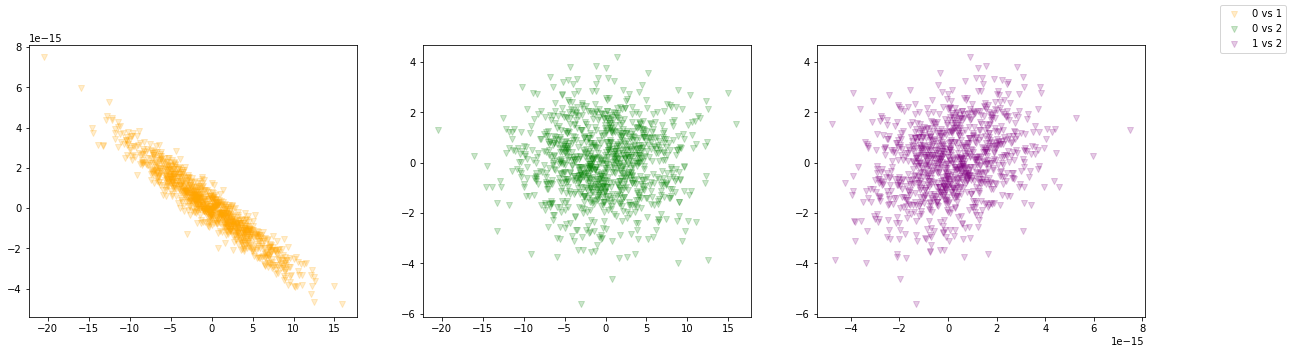

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax1.scatter(dataset[0,:],dataset[1,:], alpha=0.2, color='orange', marker='v', label='0 vs 1')
ax2.scatter(dataset[0,:],dataset[2,:], alpha=0.2, color='green', marker='v',label='0 vs 2')
ax3.scatter(dataset[1,:],dataset[2,:], alpha=0.2, color='purple', marker='v',label='1 vs 2')
fig.legend()
fig, (ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax4.scatter(rot[0,:],rot[1,:], alpha=0.2, color='orange', marker='v', label='0 vs 1')
ax5.scatter(rot[0,:],rot[2,:], alpha=0.2, color='green', marker='v',label='0 vs 2')
ax6.scatter(rot[1,:],rot[2,:], alpha=0.2, color='purple', marker='v',label='1 vs 2')
fig.legend()

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

True
True
the variability for the first eigenvalue is: (0.9252747781443861+0j)


Text(0.5, 1.0, 'Rotated scatter plot')

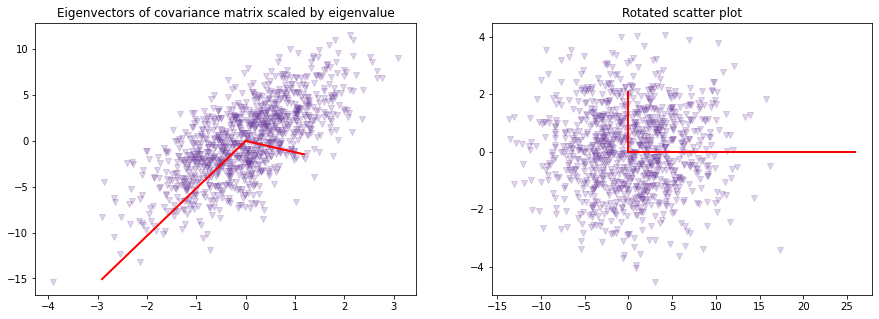

In [12]:
y1=np.random.randn(1000)
y2=y1+npr.normal(0,3,1000)
y3=2*y1+y2
NR=[npr.normal(0,1/50,1000) for i in range(10)] 
ds=np.array([y1,y2,y3])+np.sum(NR, axis=0)
covariance=np.cov(ds)
l1,V1=la.eig(covariance)
U1,spectrum1,Vt1=la.svd(covariance)
D1=np.zeros((3,3))
for i in range(min(3,3)):
    D1[i, i]=spectrum1[i]
SVD=np.dot(U1, np.dot(D1, Vt1))
lnew1,Vnew1=la.eig(SVD)
print(np.allclose(lnew1,l1))
print(np.allclose(Vnew1,V1))

Lambda=np.diag(l1)
print ('the variability for the first eigenvalue is:',Lambda[0,0]/Lambda.trace())

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.scatter(ds[0,:],ds[2,:], alpha=0.2, color='rebeccapurple', marker='v')
for n,m in zip(l1, V1.T):
    ax1.plot([0, n*m[0]], [0, n*m[1]], 'r-', lw=2)
ax1.set_title('Eigenvectors of covariance matrix scaled by eigenvalue')

rota = np.dot(V1.T, ds)
ax2.scatter(rota[0,:], rota[2,:], alpha=0.2, color='rebeccapurple', marker='v')
for g, k in zip(l1, np.diag([1]*3)):
    ax2.plot([0, g*k[0]], [0, g*k[2]], 'r-', lw=2)
ax2.set_title('Rotated scatter plot')

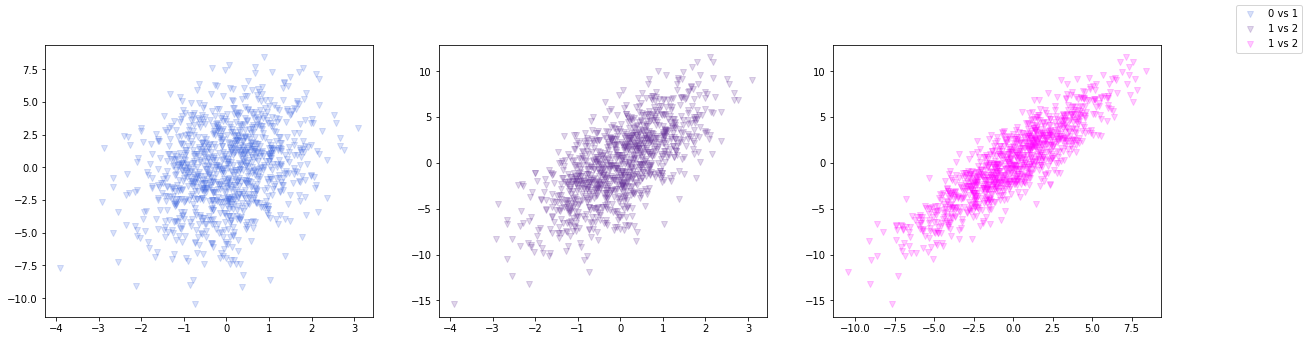

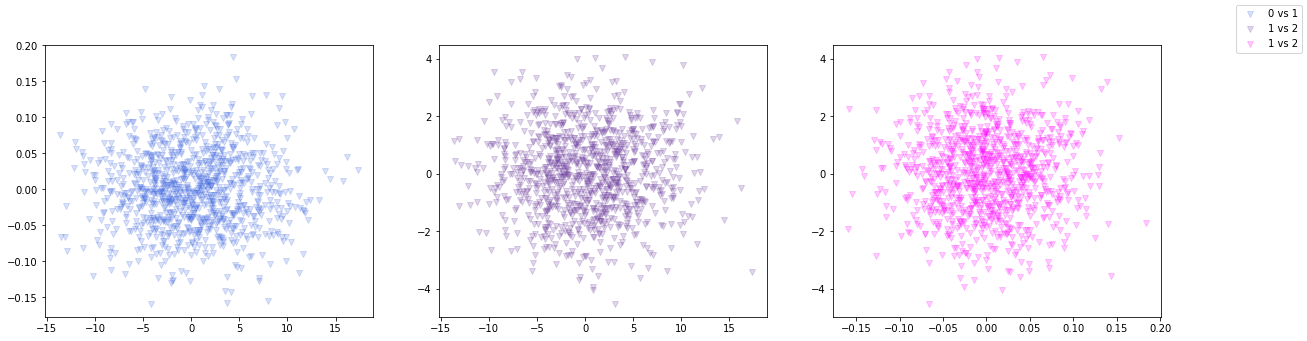

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax1.scatter(ds[0,:],ds[1,:], alpha=0.2, color='royalblue', marker='v', label='0 vs 1')
ax2.scatter(ds[0,:],ds[2,:], alpha=0.2, color='rebeccapurple', marker='v',label='1 vs 2')
ax3.scatter(ds[1,:],ds[2,:], alpha=0.2, color='magenta', marker='v', label='1 vs 2')
fig.legend()
fig, (ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax4.scatter(rota[0,:],rota[1,:], alpha=0.2, color='royalblue', marker='v', label='0 vs 1')
ax5.scatter(rota[0,:],rota[2,:], alpha=0.2, color='rebeccapurple', marker='v',label='1 vs 2')
ax6.scatter(rota[1,:],rota[2,:], alpha=0.2, color='magenta', marker='v', label='1 vs 2')
fig.legend()

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [ ]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 